In [1]:
from functions import *
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
import cv2
import os

## Edge detection

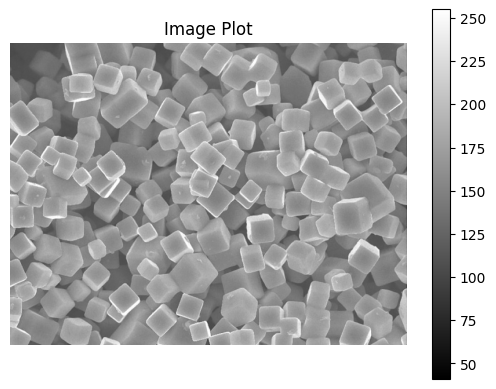

In [2]:
# get the particle
SEM_image_path = 'SEM_images/Ag3PO4_cubic.tif'
particle = cv2.imread(SEM_image_path)

# Plot the image
plt.imshow(particle, cmap='gray')
plt.colorbar()
plt.title("Image Plot")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

Número de cubos identificados:  83
Coordenadas dos centros dos cubos: [{'x': 426, 'y': 570}, {'x': 197, 'y': 570}, {'x': 300, 'y': 559}, {'x': 576, 'y': 542}, {'x': 170, 'y': 540}, {'x': 360, 'y': 532}, {'x': 759, 'y': 514}, {'x': 49, 'y': 514}, {'x': 230, 'y': 514}, {'x': 571, 'y': 503}, {'x': 137, 'y': 498}, {'x': 261, 'y': 487}, {'x': 669, 'y': 479}, {'x': 527, 'y': 470}, {'x': 215, 'y': 473}, {'x': 49, 'y': 467}, {'x': 573, 'y': 462}, {'x': 175, 'y': 463}, {'x': 277, 'y': 458}, {'x': 578, 'y': 446}, {'x': 489, 'y': 442}, {'x': 200, 'y': 436}, {'x': 711, 'y': 434}, {'x': 531, 'y': 428}, {'x': 581, 'y': 420}, {'x': 176, 'y': 415}, {'x': 658, 'y': 412}, {'x': 675, 'y': 401}, {'x': 745, 'y': 404}, {'x': 332, 'y': 406}, {'x': 199, 'y': 393}, {'x': 145, 'y': 385}, {'x': 505, 'y': 377}, {'x': 234, 'y': 370}, {'x': 746, 'y': 369}, {'x': 601, 'y': 375}, {'x': 563, 'y': 361}, {'x': 633, 'y': 367}, {'x': 64, 'y': 351}, {'x': 25, 'y': 347}, {'x': 165, 'y': 348}, {'x': 451, 'y': 346}, {'x': 240

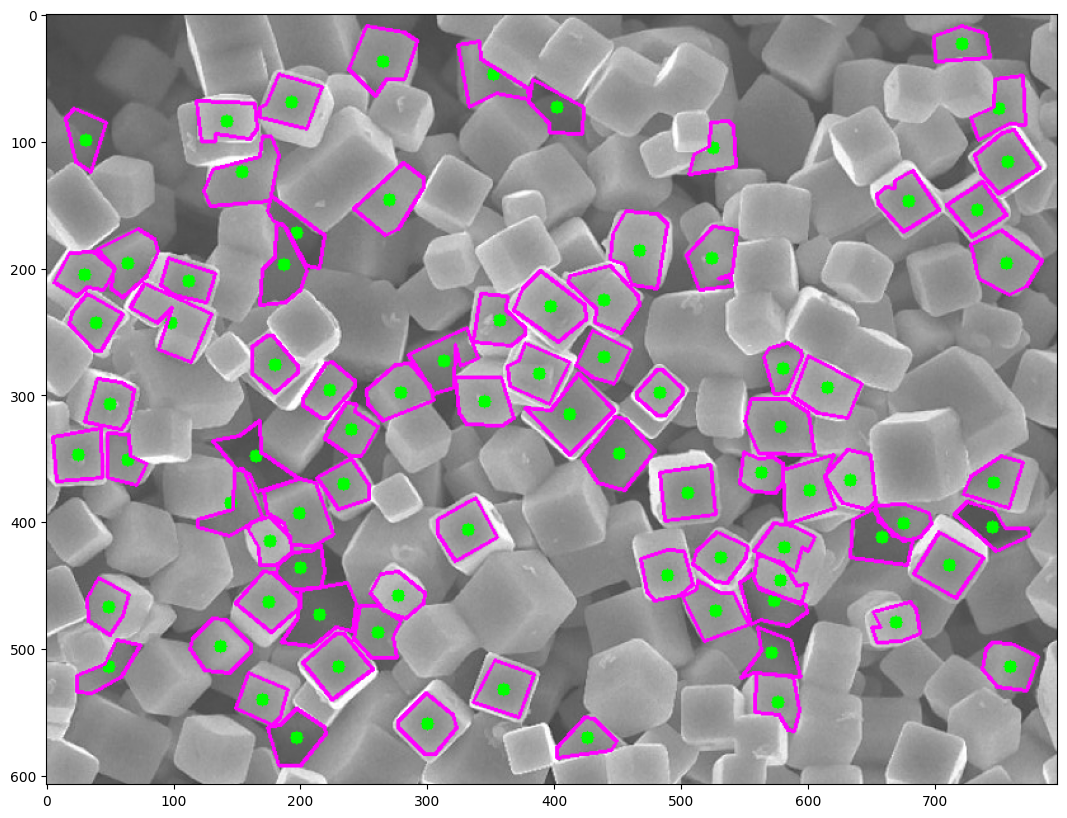

In [3]:

def identificar_centros_cubos(imagem):
        # Carregar a imagem
        filtro_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
        
        # Aplicar um filtro bilateral para suavizar a imagem preservando as bordas
        imagem_suavizada = cv2.bilateralFilter(filtro_cinza, 3, 75, 75)

        # Aplicar filtro Gaussiano
        filtro_ruido = cv2.GaussianBlur(imagem_suavizada, (5, 5), 0)

        # Detecção de bordas com Canny
        bordas = cv2.Canny(filtro_ruido, 5, 50)

        # Aplicar operações morfológicas para limpar a imagem binarizada
        kernel = np.ones((5, 5), np.uint8)
        imagem_morfo = cv2.morphologyEx(bordas, cv2.MORPH_CLOSE, kernel)
        cv2.imshow('imagem_morfo', imagem_morfo)
        #imagem_morfo1 = cv2.morphologyEx(imagem_morfo, cv2.MORPH_OPEN, kernel)
        #cv2.imshow('imagem_morfo1', imagem_morfo1)

        # Encontrar contornos
        # 4. Detectar os contornos dos cubos
        contornos, _ = cv2.findContours(imagem_morfo, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Inicializar uma lista para armazenar as coordenadas dos centros dos cubos
        centros_cubos = []

        # Filtrar e desenhar contornos
        for contorno in contornos:
            # Aproximar o contorno para uma forma poligonal
            epsilon = 0.02 * cv2.arcLength(contorno, True)
            aproximacao = cv2.approxPolyDP(contorno, epsilon, True)

            # Verificar se o polígono tem 4 lados e uma área significativa
            if len(aproximacao) <= 8 and cv2.contourArea(aproximacao) > 750 and cv2.contourArea(aproximacao) < 2000:  # Ajustar a área mínima conforme necessário
                # Verificar se é aproximadamente um quadrado (aspecto de cubo)
                (x, y, w, h) = cv2.boundingRect(aproximacao)
                razao_aspecto = w / h
                if 0.5 <= razao_aspecto <= 2:
                    # Calcular o centro do cubo
                    centro_x = x + w // 2
                    centro_y = y + h // 2
                    centros_cubos.append({
                        'x': centro_x,
                        'y': centro_y
                    })

                    # Marcar o centro na imagem
                    cv2.circle(imagem, (centro_x, centro_y), 5, (0, 255, 0), -1)
                    cv2.drawContours(imagem, [aproximacao], 0, (255, 0, 255), 2)
                    #cv2.rectangle(imagem, (x, y), (x + w, y + h), (0, 0, 255), 2)

        # Retornar a imagem processada e as coordenadas dos centros dos cubos
        return imagem, centros_cubos

# Exemplo de uso
# Carregar a imagem
imagem = cv2.imread('SEM_images/Ag3PO4_cubic.tif')

# Chamar a função para identificar os centros dos cubos
imagem_processada, centros_identificados = identificar_centros_cubos(imagem)

# Exibir a imagem processada
cv2.imshow('Centros dos Cubos Identificados', imagem_processada)
plt.figure(figsize=(20, 10))
plt.imshow(imagem_processada)
print("Número de cubos identificados: ", len(centros_identificados))
cv2.waitKey(0)
cv2.destroyAllWindows()

# Imprimir as coordenadas dos centros dos cubos identificados
print("Coordenadas dos centros dos cubos:", centros_identificados)

In [15]:
output_dir = 'SEM_images/cropped_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# tamanho da imagem cortada
crop_size = 70
half_crop_size = crop_size // 2

# loop das posicoes
for i, centro in enumerate(centros_identificados):
    x_center, y_center = centro['x'], centro['y']

    x_start = max(x_center - half_crop_size, 0)
    y_start = max(y_center - half_crop_size, 0)

    x_end = min(x_start + crop_size, imagem.shape[1])
    y_end = min(y_start + crop_size, imagem.shape[0])

    x_start = x_end - crop_size if x_end - x_start < crop_size else x_start
    y_start = y_end - crop_size if y_end - y_start < crop_size else y_start

    cropped_image = imagem[y_start:y_end, x_start:x_end]

    # Salvar imagem
    output_path = os.path.join(output_dir, f'cropped_{i+1}.tif')
    cv2.imwrite(output_path, cropped_image)


In [14]:
edge = edge_finder(particle)

# Plot the image
plt.imshow(edge, cmap='gray')
plt.colorbar()
plt.title("Image Plot")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

IndexError: tuple index out of range